### Lorentz System

$\frac{\mathrm{d}x}{\mathrm{d}t} = \sigma (y - x), \\[6pt]$


$\frac{\mathrm{d}y}{\mathrm{d}t} = x (\rho - z) - y, \\[6pt]$


$\frac{\mathrm{d}z}{\mathrm{d}t} = x y - \beta z.$

$σ = 10$, $β = 8/3$ and $ρ = 28$

$x(0) = 0$, $y(0) = 1$, $z(0) = 1.05$

In [240]:
from typing import List, Tuple, Callable
from autograd import grad, elementwise_grad
from matplotlib import pyplot as plt
import autograd.numpy as np

In [352]:
XYZ_0 = np.array([0, 1, 1.05])
SBR = np.array([10, 8/3, 28])

def lorenz_derivatives(xyz, *, sbr=SBR) -> np.ndarray:
    """The Lorenz derivatives.
    
    Args:
        xyz : array-like, shape (3,)
        srb: array-like, shape (3,)

    Returns:
         xyz_dot : array, shape (3,)
            Values of the Lorenz attractor's partial derivatives at *xyz*.
    """
    s, b, r = sbr
    x, y, z = xyz
    x_dot = s * (y - x)
    y_dot = r * x - y - x * z
    z_dot = x * y - b * z
    return np.array([x_dot, y_dot, z_dot])

### Activation Functions

In [353]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def tanh(z):
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))


def elu(z, alpha: float):
    return alpha * (np.exp(z) - 1) if z < 0 else z

### Neural Network

![](NN.png "Neural Network")

In [ ]:
class NeuralNetwork:
    """A neural network class for solving ODEs or system of ODEs.
        Attributes:
            init_conditions (np.array): Initial conditions for the target function.
            coefs (np.array): Coefficients for the target function.
            derivative (Callable): Function that calculates the target derivative of the neural network.
            input_size (int): Size of the input layer.
            hidden_sizes (np.array): Array of integers representing the sizes of the hidden layers.
            output_size (int): Size of the output layer.
            activation_fns (List[Callable]): List of activation functions for each layer.
            weights (List[np.array]): List of weights and biases for each layer.

        Methods:
            init_weights(): Initializes the weights and biases of the neural network.
            forward(t: np.array, weights: List[np.array]) -> np.array: Makes a forward pass through the neural network.
            mse_loss_function(t: np.array, weights: List[np.array]) -> float: Calculates the mean squared error of the neural network.
            trial_solution(t: np.array, weights: List[np.array]) -> np.ndarray: Calculates the trial solution.
            trial_grad(t: np.array, weights: List[np.array]) -> np.array: Calculates the gradient of the trial solution with respect to t.
            gradient_descent(t: np.array, num_iter: int, learn_rate: float) -> List[np.array]: Runs gradient descent for a given number of iterations.
    """
    def __init__(self, init_conditions: np.array, derivative: Callable, input_size: int, hidden_sizes: np.array, output_size: int, activation_fns: List[Callable]):
        self.init_conditions = init_conditions
        self.derivative = derivative
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.activation_fns = activation_fns
        self.weights = [None] * (hidden_sizes.shape[0] + 1) # +1 for the output
        self.init_weights()

    def init_weights(self):
        """ Initializes the weights and biases of the neural network 
        Args:
            None
        
        Returns:
            None
        """
        # hidden weights and biases
        self.weights[0] = np.random.randn(self.hidden_sizes[0], self.input_size + 1) # +1 for the bias
        for i in range(1, self.hidden_sizes.shape[0]):
            self.weights[i] = np.random.randn(self.hidden_sizes[i], self.hidden_sizes[i - 1] + 1) # +1 for the bias

        # output weights and biases
        self.weights[-1] = np.random.randn(self.output_size, self.hidden_sizes[-1] + 1) # +1 for the bias

    def forward(self, t: np.array, weights: List[np.array]) -> np.array:
        """Makes a forward pass through the neural network.

        Args:
            t: The t vector
            weights: The weights and biases of the neural network
        
        Returns:
            A NumPy array of the output of the neural network of dim(3, len(t)).
        """
        num_layers = len(weights)
        # row matrix
        t = t.reshape(-1, t.size)

        z = None
        a = t
        for i in range(num_layers):
            z = np.matmul(weights[i], np.concatenate((np.ones((1, t.size)), a), axis = 0))
            a = self.activation_fns[i](z)
        
        return z

    def mse_loss_function(self, t: np.array, weights: List[np.array]) -> float:
        """Calculates the mean squared error of the neural network.

        Args:
            t: The input vector
            weights: The weights and biases of the neural network

        Returns:
            Mean squared error value
        
        """
        trial_sol = self.trial_solution(t, weights)
        grad_star = self.derivative(t, trial_sol)
        grad = self.trial_grad(t, weights)
        error = grad_star - grad

        return np.linalg.norm(error, 'fro') / np.sqrt(np.size(error))

    def trial_solution(self, t: np.array, weights: List[np.array]) -> np.ndarray:
        """Calculates the trial solution of the system of ODEs.
        
        Args:
            t: The input vector
            weights: The weights and biases of the neural network
        
        Returns:
            A NumPy array of the trial solution of the system of ODEs
            dimension (self.output_size, len(t))
        """
        fp = self.forward(t, weights)
        return np.array([self.init_conditions[i] + t * fp[i] for i in range(self.output_size)])

    def elementwise_trial_solution(self, t: np.array, weights: List[np.array], index):
        return self.trial_solution(t, weights)[index]

    def trial_grad(self, t: np.array, weights: List[np.array]) -> np.array:
        """Calculates the gradient of the trial solution of the Lorentz System.
        
        Args:
            t: The input vector
            weights: The weights and biases of the neural network
        
        Returns:
            A NumPy array of the gradient of the trial solution of the Lorentz System with 
            dimension (self.output_size, len(t))
        """
        return np.array([elementwise_grad(self.elementwise_trial_solution, 0)(t, weights, i) for i in range(self.output_size)])

    def gradient_descent(self, t: np.array, num_iter: int, learn_rate: float):
        """Runs gradient descent for a given number of iterations

        Args:
            t: The input vector
            num_iter: The number of iterations
            learn_rate: The learning rate
        
        Returns:
            weights: The weights and biases of the neural network after gradient descent
        """
        loss_grad_function = grad(self.mse_loss_function, 1)

        for i in range(num_iter):
            print("iteration: ", i)
            print(self.mse_loss_function(t, self.weights))
            loss_grad = loss_grad_function(t, self.weights)
            
            for j in range(len(self.weights)):
                self.weights[j] = self.weights[j] - learn_rate * loss_grad[j]

        return self.weights
    
    def adam(self, t, grad, num_iters=10000, step_size=0.001, b1=0.9, b2=0.999, eps=10**-8):
        loss_grad_function = grad(self.mse_loss_function, 1)

        m = [np.zeros_like(self.weights[i]) for i in range(len(self.nn_weights))]
        v = [np.zeros_like(self.weights[i]) for i in range(len(self.nn_weights))]
        mhat = [None] * len(self.weights)
        vhat = [None] * len(self.weights)
        for i in range(num_iters):
            g = loss_grad_function(t, self.weightss)
            print("iteration: ", i)
            print(self.mse_loss_function(t, self.nn_weights))
            
            for j in range(len(self.weights)):
                m[j] = (1 - b1) * g[j]      + b1 * m[j]  # First  moment estimate.
                v[j] = (1 - b2) * (g[j]**2) + b2 * v[j]  # Second moment estimate.
                mhat[j] = m[j] / (1 - b1**(i + 1))    # Bias correction.
                vhat[j] = v[j] / (1 - b2**(i + 1)) 
                self.weights[j] = self.weights[j] - step_size * mhat[j]/(np.sqrt(vhat[j]) + eps)
        
        return self.weights

### Training

In [374]:
def train_lorenz(init_conditions, sbr):
    t = np.arange(0, 10, 0.01)
    hidden_sizes = np.array([100, 100, 100])
    activation_fns = [tanh] * (len(hidden_sizes)) + [lambda x: x]
    lorenz_nn = NeuralNetwork(init_conditions, sbr, lorenz_derivatives, 1, hidden_sizes, 3, activation_fns)
    lorenz_nn.gradient_descent(t, 1000, 0.00001)

    return lorenz_nn

lorenz_nn = train_lorenz(XYZ_0, SBR)

iteration:  0
325.60620700635803
iteration:  1
269.5608673875736
iteration:  2
223.4039508356441
iteration:  3
202.93861671350822
iteration:  4
192.92438282875932
iteration:  5
185.30636181163453
iteration:  6
178.42618558021073
iteration:  7
171.44350402728548
iteration:  8
163.90042208586243
iteration:  9
156.31720962056784
iteration:  10
149.97764353182157
iteration:  11
144.9452411065707
iteration:  12
140.5967884446334
iteration:  13
136.61033067733982
iteration:  14
132.8665134725547
iteration:  15
129.31971301074913
iteration:  16
125.95367720488676
iteration:  17
122.76786648563265
iteration:  18
119.7735501423626
iteration:  19
116.9894973905179
iteration:  20
114.43416200539129
iteration:  21
112.11704090533769
iteration:  22
110.03362790129914
iteration:  23
108.16601041194414
iteration:  24
106.48755575010826
iteration:  25
104.96855864739125
iteration:  26
103.58061475295102
iteration:  27
102.29908422981462
iteration:  28
101.10398545151097
iteration:  29
99.9799057555065

### Evaluating Results

In [383]:
def plot(neural_network: NeuralNetwork, scale=1, dt=0.01):
   t = np.arange(0, 10, dt)
   res = neural_network.forward(t, neural_network.weights)
   fig = plt.figure(figsize=(10, 10))
   ax = fig.add_subplot(projection="3d")
   ax.set_xlabel("X Axis")
   ax.set_ylabel("Y Axis")
   ax.set_zlabel("Z Axis")
   ax.plot(res[0], res[1], res[2], lw=1)

   xyzs, dxyz_dt = simulate_sode(t, neural_network.init_conditions, derivative=lorenz_derivatives)
   ax.plot(xyzs[:, 0], xyzs[:, 1], xyzs[:, 2], lw=1)

def simulate_sode(t, initial_conditions, derivative) -> Tuple[np.ndarray, np.ndarray]:
   """Simulate the system of ODEs over the time interval [0, dt * num_steps].

   Args:
      dt: The time step
      initial_conditions: The initial conditions as a NumPy array of length 3
      num_steps: The number of time steps to calculate
   
   Returns:
      A tuple of two NumPy arrays: the x, y, and z values, and the derivatives.
   """
   dxyz_dt = np.empty((len(t), 3))
   xyzs = np.empty((len(t), 3))
   xyzs[0] = initial_conditions

   for i in range(len(t) - 1):
      dt = t[i + 1] - t[i]
      xyzs[i + 1] = xyzs[i] + derivative(xyzs[i]) * dt
      dxyz_dt[i] = derivative(xyzs[i])
   
   return xyzs, dxyz_dt

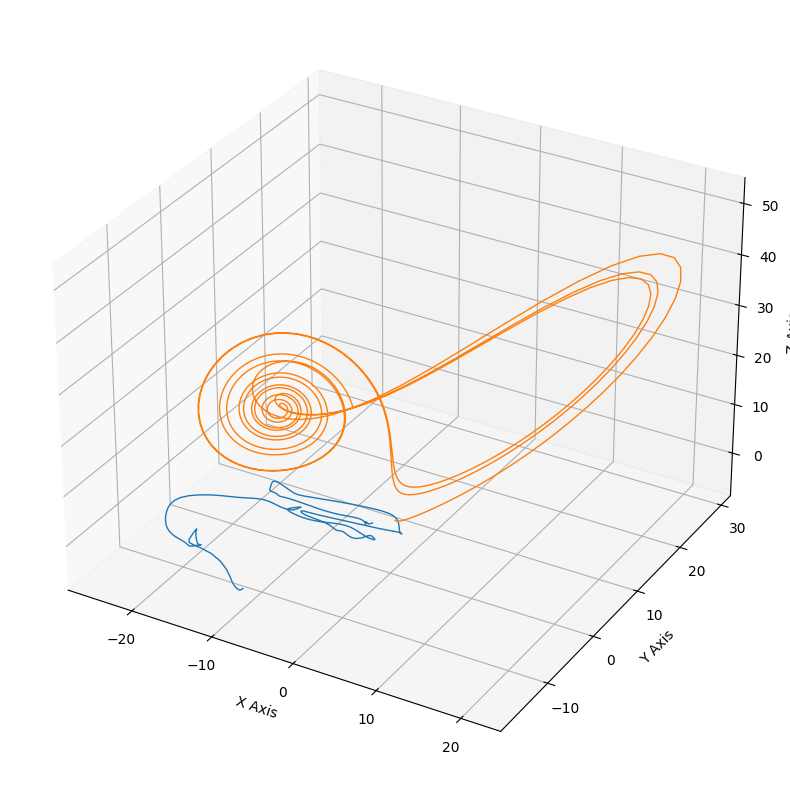

In [384]:
plot(lorenz_nn)